In [1]:
import h5py, torch, time, datetime, os
import matplotlib.pyplot as plt
from torch import nn
from torch.nn.modules import Module
from tabulate import tabulate
import copy

In [13]:
class OurModel(nn.Module):
    def __init__(self, AR = [1, 3, 3, 1] , AF = 'ReLU', WC = 1 ):               
        super(OurModel, self).__init__() 
        self.L1perUnit = WC
        ValidActivationFunctions = {'ReLU': torch.relu, 'Sigmoid': torch.sigmoid}
        try:
            self.ActivationFunction = ValidActivationFunctions[AF]
        except KeyError:
            print('The activation function specified is not valid. Allowed activations are %s.'
                 %str(list(ValidActivationFunctions.keys())))
            print('Will use ReLU.')
            self.ActivationFunction = torch.relu            
        if type(AR) == list:
            if( ( all(isinstance(n, int) for n in AR)) and ( AR[-1] == 1) ):
                self.Architecture = AR
            else:
                print('Architecture should be a list of integers, the last one should be 1.')
                raise ValueError             
        else:
            print('Architecture should be a list !')
            raise ValueError

### Define Layers
        self.LinearLayerList  = nn.ModuleList([nn.Linear(self.Architecture[i], 
            self.Architecture[i+1]) for i in range(len(self.Architecture)-2)])
        self.OutputLayer = nn.Linear(self.Architecture[-2], 1)       

    def Forward(self, Data):
### Forward Function. Performs Preprocessing, returns f = nn from -inf to +inf
        # Checking that data has the right input dimension
        InputDimension = self.Architecture[0]
        if Data.size(1) != InputDimension:
            print('Dimensions of the data and the network input mismatch: data: %d, model: %d'
                  %(Data.size(1), InputDimension))
            raise ValueError

        # Checking that preprocess has been initialised
        if not hasattr(self, 'Shift'):
            print('Please initialize preprocess parameters!')
            raise ValueError
        with torch.no_grad(): 
            Data = self.Preprocess(Data)  
        
        x = Data
        
        for i, Layer in enumerate(self.LinearLayerList):
            x = self.ActivationFunction(Layer(x)) 
        f = self.OutputLayer(x).squeeze()
          
        return f.view(-1, 1)
    
    def ClipL1Norm(self):
### Clip the weights      
        def ClipL1NormLayer(DesignatedL1Max, Layer, Counter):
            if Counter == 1:
                ### this avoids clipping the first layer
                return
            L1 = Layer.weight.abs().sum()
            Layer.weight.masked_scatter_(L1 > DesignatedL1Max, 
                                        Layer.weight*(DesignatedL1Max/L1))
            return
        
        Counter = 0
        for m in self.children():
            if isinstance(m, nn.Linear):
                Counter += 1
                with torch.no_grad():
                    DesignatedL1Max = m.weight.size(0)*m.weight.size(1)*self.L1perUnit
                    ClipL1NormLayer(DesignatedL1Max, m, Counter)
            else:
                for mm in m:
                    Counter +=1
                    with torch.no_grad():
                        DesignatedL1Max = mm.weight.size(0)*mm.weight.size(1)*self.L1perUnit
                        ClipL1NormLayer(DesignatedL1Max, mm, Counter)
        return 
    
    def InitPreprocess(self, Data):
### This can be run only ONCE to initialize the preprocess (shift and scaling) parameters
### Takes as input the training Data and the training Parameters as Torch tensors.
        if not hasattr(self, 'Scaling'):
            print('\nInitializing Preprocesses Variables')
            self.Scaling = Data.std(0)
            self.Shift = Data.mean(0) 
        else: print('Preprocess can be initialized only once. Parameters unchanged.')
            
    def Preprocess(self, Data):
### Returns scaled/shifted data and parameters
### Takes as input Data and Parameters as Torch tensors.
        if  not hasattr(self, 'Scaling'): print('Preprocess parameters are not initialized.')
        Data = (Data - self.Shift)/self.Scaling
        return Data
    
    def Report(self): ### is it possibe to check if the model is in double?
        print('\nModel Report:')
        print('Preprocess Initialized: ' + str(hasattr(self, 'Shift')))
        print('Architecture: ' + str(self.Architecture))
        print('Activation: ' + str(self.ActivationFunction))
        
    def cuda(self):
        nn.Module.cuda(self)
        self.Shift = self.Shift.cuda()
        self.Scaling = self.Scaling.cuda()
        
    def cpu(self):
        self.Shift = self.Shift.cpu()
        self.Scaling = self.Scaling.cpu()
        return nn.Module.cpu(self)

def OurCudaTensor(input):
    output = copy.deepcopy(input)
    output = output.cuda()
    return output

class DataFile():
### Reads sample file Info (string), Parameters (list), Values (torch array), Data (torch array) and Weights (torch array)
### FilePath is the path of the input file
### Computes cross-section XS (average weight) and total number of data ND in file
### Checks that files are in correct format (correct Keys)
### and that the length of Parameters and Data equals the one of Values and Weights respectively
    def __init__(self, FilePath, verbose=True):
        if verbose: print('\nReading file ...' + FilePath)
        file = h5py.File(FilePath, 'r')
        if list(file.keys()) == ['Data']:
            self.FilePath = FilePath
            self.Data = torch.DoubleTensor(file['Data'][()])
            self.ND = len(self.Data)
        else:
            print('--> File format not valid:\nKeys: ' + str(list(file.keys())) + 
                  '\nshould be: ' + str(['Data']))
            raise ValueError
            
class OurTrainer(nn.Module):
### Contains all parameters for training: Loss Function, Optimiser, NumberOfEpochs, InitialLearningRate 
    def __init__(self, ExpinRefModel, LearningRate = 1e-3, Optimiser = 'Adam', NumEpochs = 100):
        super(OurTrainer, self).__init__() 
        self.ExpinR = ExpinRefModel
        self.NumberOfEpochs = NumEpochs
        self.InitialLearningRate = LearningRate
        ValidOptimizers = {'Adam': torch.optim.Adam, 'SGD': torch.optim.SGD}
        self.Criterion = MLLoss()
        try:
            self.Optimiser =  ValidOptimizers[Optimiser]
        except KeyError:
            print('The specified optimiser is not valid. Allowed optimisers are %s.'
                 %str(list(ValidOptimisers)))
            print('Will use Adam.')    
            
    def Train(self, modelIN, Data0IN, Data1IN, L1perUnit=None, 
              UseGPU=True, Name="", Folder=os.getcwd()):

        if UseGPU: 
            model = copy.deepcopy(modelIN)
            model.cuda()
            Data0 = OurCudaTensor(Data0IN)
            Data1 = OurCudaTensor(Data1IN)
        else:
            model = modelIN
            Data0 = Data0IN
            Data1 = Data1IN
            
        Optimiser = self.Optimiser(model.parameters(), self.InitialLearningRate)
        
                    
        Optimiser = self.Optimiser(model.parameters(), self.InitialLearningRate, amsgrad=False)
        #Optimiser = torch.optim.Adagrad(model.parameters())
        #Optimiser = torch.optim.AdamW(model.parameters())
        #Optimiser = torch.optim.Adadelta(model.parameters())
        Optimiser = torch.optim.Adamax(model.parameters()) ## Good on sameple 11
        #scheduler = torch.optim.lr_scheduler.StepLR(Optimiser, step_size=50, gamma=.2)
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(Optimiser, factor=.1, patience=10, verbose = True,
                             #threshold=1, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
        
        thistory = []
        ehistory = []
        for e in range(self.NumberOfEpochs):
            #print("epoch")
            Optimiser.zero_grad()
            output0          = model.Forward(Data0)
            output1          = model.Forward(Data1)
            loss            = self.Criterion(output0, output1, self.ExpinR)
            print ("t = " + str(-2.*loss.item()) +  " at epoch = " + str(e), end='\r')
            ehistory.append(e)
            thistory.append(-2.*loss.item())
            loss.backward()
            Optimiser.step()
            model.ClipL1Norm()
        return ehistory, thistory
    
####### Loss function
from torch.nn.modules.loss import _Loss
class MLLoss(_Loss):
    __constants__ = ['reduction']
        
    def __init__(self, size_average=None, reduce=None, reduction='mean'):
        super(MLLoss, self).__init__(size_average, reduce, reduction)
    def forward(self, input0, input1, ExpinR):
        ExpoverR = ExpinR/input0.size()[0]
        return torch.sum(ExpoverR*(torch.exp(input0) - 1.)) - torch.sum(input1)


Reading file ...Reference_sample/1.h5

Reading file ...BSM_toys/11.h5

Reference data lenght =  200000

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method sigmoid of type object at 0x1186f7ad0>


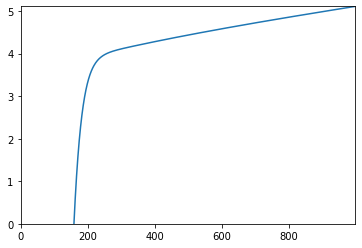

In [14]:
torch.manual_seed(0)
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('BSM_toys/11.h5')
Nexp = 2000.
NReftotal = RF.Data.size()[0]
print('\nReference data lenght = ', NReftotal)
MD = OurModel(AR = [1, 4, 1], AF = 'Sigmoid' )
MD.double()
MD.InitPreprocess(torch.cat([RF.Data, DF.Data]))
MD.Report()
MT = OurTrainer(Nexp, NumEpochs = 1000, LearningRate = 1e-3, Optimiser = 'Adam')
start = time.time()
epoch, t = MT.Train(MD, RF.Data, DF.Data, UseGPU = False)
plt.axis([0, max(epoch), 0, max(t)])
plt.plot(epoch,t)

In [9]:
## GPU with more data
torch.manual_seed(0)
RF = DataFile('Reference_sample/2.h5')
DF = DataFile('SM_toys/11.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1], AF = 'Sigmoid' , WC = 100)
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 10000, LearningRate = 1e-3, Optimiser = 'Adam')
start = time.time()
epoch, t = MT.Train(MD, TData, TLabels, UseGPU = True)
print('Training time = ' + str((time.time()-start)))
plt.axis([0, max(epoch), 0, max(t)])
plt.plot(epoch,t)


Reading file ...Reference_sample/2.h5

Reading file ...SM_toys/11.h5

Reference data lenght =  400000


NameError: name 'TrainingDataSample' is not defined


Reading file ...Reference_sample/1.h5

Reading file ...SM_toys/11.h5

Reference data lenght =  200000

Total number of training points  =  202029

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method sigmoid of type object at 0x7ff247514c40>
Training time = 114.30339312553406999983


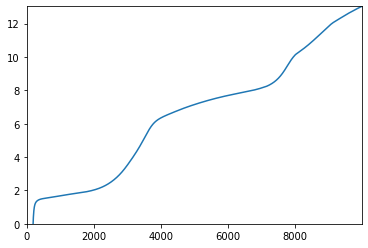

In [4]:
## GPU
torch.manual_seed(0)
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('SM_toys/11.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1], AF = 'Sigmoid' , WC = 100)
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 10000, LearningRate = 1e-3, Optimiser = 'Adam')
start = time.time()
epoch, t = MT.Train(MD, TData, TLabels, UseGPU = True)
print('Training time = ' + str((time.time()-start)))
plt.axis([0, max(epoch), 0, max(t)])
plt.plot(epoch,t)


Reading file ...Reference_sample/1.h5

Reading file ...SM_toys/11.h5

Reference data lenght =  200000

Total number of training points  =  202029

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method sigmoid of type object at 0x7ff247514c40>
Training time = 142.20874357223519999742


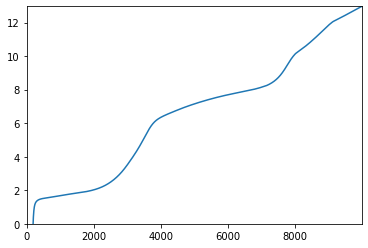

In [3]:
## CPU
torch.manual_seed(0)
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('SM_toys/11.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1], AF = 'Sigmoid' , WC = 100)
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 10000, LearningRate = 1e-3, Optimiser = 'Adam')
start = time.time()
epoch, t = MT.Train(MD, TData, TLabels, UseGPU = False)
print('Training time = ' + str((time.time()-start)))
plt.axis([0, max(epoch), 0, max(t)])
plt.plot(epoch,t)


Reading file ...Reference_sample/1.h5

Reading file ...SM_toys/11.h5

Reference data lenght =  200000

Total number of training points  =  202029

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method sigmoid of type object at 0x7f340375fc40>
Training time = 515.0609629154205 999992


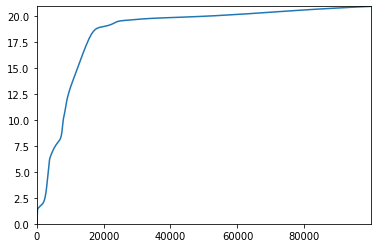

In [125]:
## With ADAM
torch.manual_seed(0)
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('SM_toys/11.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1], AF = 'Sigmoid' , WC = 100)
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 100000, LearningRate = 1e-3, Optimiser = 'Adam')
start = time.time()
epoch, t = MT.Train(MD, TData, TLabels, UseGPU = True)
print('Training time = ' + str((time.time()-start)))
plt.axis([0, max(epoch), 0, max(t)])
plt.plot(epoch,t)


Reading file ...Reference_sample/1.h5

Reading file ...SM_toys/11.h5

Reference data lenght =  200000

Total number of training points  =  202029

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method sigmoid of type object at 0x7f340375fc40>
Training time = 516.690776348114= 999992


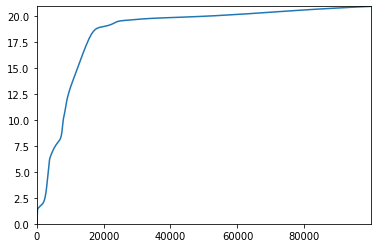

In [126]:
## With ADAMAX
torch.manual_seed(0)
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('SM_toys/11.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1], AF = 'Sigmoid' , WC = 100)
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 100000, LearningRate = 1e-3, Optimiser = 'Adam')
start = time.time()
epoch, t = MT.Train(MD, TData, TLabels, UseGPU = True)
print('Training time = ' + str((time.time()-start)))
plt.axis([0, max(epoch), 0, max(t)])
plt.plot(epoch,t)


Reading file ...Reference_sample/1.h5

Reading file ...SM_toys/11.h5

Reference data lenght =  200000

Total number of training points  =  202029

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method sigmoid of type object at 0x7f340375fc40>
10.6514481030531563156 at epoch = 99999
Training time = 474.8793168067932


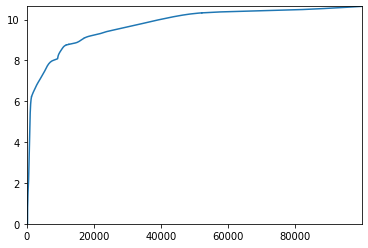

In [130]:
## With ADAM, Train1
torch.manual_seed(0)
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('SM_toys/11.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1], AF = 'Sigmoid' , WC = 100)
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 100000, LearningRate = 1e-3, Optimiser = 'Adam')
start = time.time()
epoch, t = MT.Train1(MD, TData, TLabels, UseGPU = True)
print('Training time = ' + str((time.time()-start)))
plt.axis([0, max(epoch), 0, max(t)])
plt.plot(epoch,t)


Reading file ...Reference_sample/1.h5

Reading file ...SM_toys/4.h5

Reference data lenght =  200000

Total number of training points  =  201965

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method sigmoid of type object at 0x7f340375fc40>
300
0.7708561555250668
500
0.006371840149007824
52500
0.0010556146599327576
82400
0.0006677851084226916
12.388448409832773
Training time = 434.3195540904999


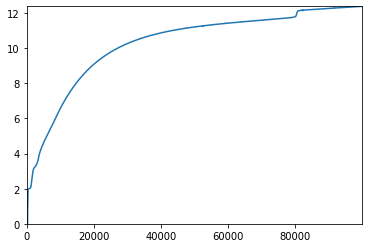

In [83]:
torch.manual_seed(0)
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('SM_toys/4.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1], AF = 'Sigmoid' , WC = 100)
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 100000, LearningRate = 1e-3, Optimiser = 'Adam')
start = time.time()
epoch, t = MT.Train1(MD, TData, TLabels, UseGPU = True)
print('Training time = ' + str((time.time()-start)))
plt.axis([0, max(epoch), 0, max(t)])
plt.plot(epoch,t)


Reading file ...Reference_sample/1.h5

Reading file ...SM_toys/4.h5

Reference data lenght =  200000

Total number of training points  =  201965

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method sigmoid of type object at 0x7f340375fc40>
Training time = 265.02531886100779999621


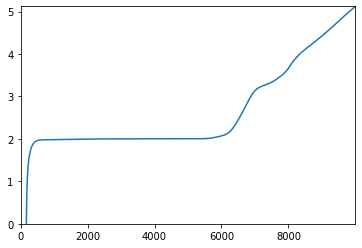

In [135]:
torch.manual_seed(0)
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('SM_toys/4.h5')
Nexp = 2000.
NRef = RF.Data[:200000].size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data[:200000], DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1], AF = 'Sigmoid' , WC = 100)
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 10000, LearningRate = 1e-3, Optimiser = 'Adam')
start = time.time()
epoch, t = MT.Train(MD, TData, TLabels, UseGPU = False)
print('Training time = ' + str((time.time()-start)))
plt.axis([0, max(epoch), 0, max(t)])
plt.plot(epoch,t)

In [137]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  32


In [143]:
for i in range(10): print(i)

0
1
2
3
4
5
6
7
8
9


In [170]:
start = time.time()
def f(i):
    torch.manual_seed(0)
    RF = DataFile('Reference_sample/1.h5')
    DF = DataFile('SM_toys/4.h5')
    Nexp = 2000.
    NRef = RF.Data[:200000].size()[0]
    TData, TLabels = TrainingDataSample(RF.Data[:200000], DF.Data)
    MD = OurModel(AR = [1, 4, 1], AF = 'Sigmoid' , WC = 100)
    MD.double()
    MD.InitPreprocess(TData)
    MT = OurTrainer(Nexp/NRef, NumEpochs = 1, LearningRate = 1e-3, Optimiser = 'Adam')
    MT.Train(MD, TData, TLabels, UseGPU = False)
ctx = mp.get_context('spawn')
with ctx.Pool(mp.cpu_count()) as pool:
    res = pool.map(f, [i for i in range(1)])
print('Training time = ' + str((time.time()-start)))
print(res)
pool.close()

KeyboardInterrupt: 

In [151]:
print(res[0])

TypeError: 'MapResult' object is not subscriptable

In [140]:
range(10)

range(0, 10)


Reading file ...Reference_sample/1.h5

Reading file ...SM_toys/4.h5

Reference data lenght =  200000

Total number of training points  =  201965

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method sigmoid of type object at 0x7f340375fc40>
Training time = 51.282803297042859999621


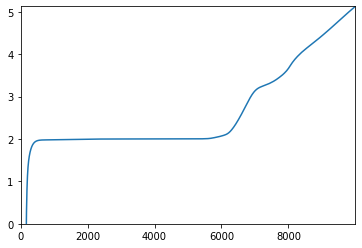

In [136]:
torch.manual_seed(0)
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('SM_toys/4.h5')
Nexp = 2000.
NRef = RF.Data[:200000].size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data[:200000], DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1], AF = 'Sigmoid' , WC = 100)
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 10000, LearningRate = 1e-3, Optimiser = 'Adam')
start = time.time()
epoch, t = MT.Train(MD, TData, TLabels, UseGPU = True)
print('Training time = ' + str((time.time()-start)))
plt.axis([0, max(epoch), 0, max(t)])
plt.plot(epoch,t)


Reading file ...Reference_sample/1.h5

Reading file ...SM_toys/4.h5

Reference data lenght =  200000

Total number of training points  =  201965

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method sigmoid of type object at 0x7f340375fc40>
Training time = 39.07765603065491 99997


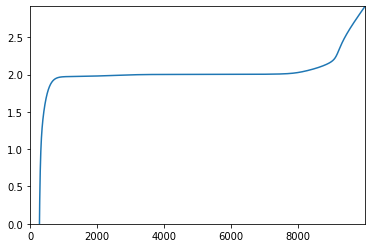

In [54]:
torch.manual_seed(0)
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('SM_toys/4.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1], AF = 'Sigmoid' , WC = 100)
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 10000, LearningRate = 1e-3, Optimiser = 'Adam')
start = time.time()
epoch, t = MT.Train(MD, TData, TLabels, UseGPU = True)
print('Training time = ' + str((time.time()-start))
plt.axis([0, max(epoch), 0, max(t)])
plt.plot(epoch,t)


Reading file ...Reference_sample/1.h5

Reading file ...SM_toys/4.h5

Reference data lenght =  200000

Total number of training points  =  201965

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method sigmoid of type object at 0x7f340375fc40>
Training time = 34.61289858818054999984


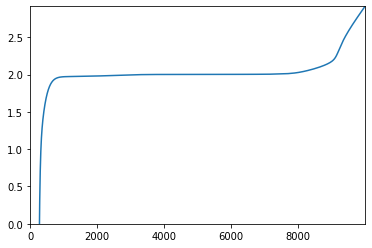

In [59]:
torch.manual_seed(0)
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('SM_toys/4.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1], AF = 'Sigmoid' , WC = 100)
#MD.double()
MD.InitPreprocess(TData.type(torch.float))
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 10000, LearningRate = 1e-3, Optimiser = 'Adam')
start = time.time()
epoch, t = MT.Train(MD, TData.type(torch.float), TLabels.type(torch.float), UseGPU = True)
print('Training time = ' + str((time.time()-start)))
plt.axis([0, max(epoch), 0, max(t)])
plt.plot(epoch,t)

In [73]:
a = torch.DoubleTensor([2.])
a = torch.log(a)
print('%.15f' % a)
b = torch.Tensor([2.])
b = torch.log(b)
print('%.15f' % b)
ac = torch.DoubleTensor([2.])
acud = ac.cuda()
acud = torch.log(acud)
print('%.15f' % acud)
bc = torch.Tensor([2.])
bcud = bc.cuda()
bcud = torch.log(bcud)
print('%.15f' % bcud)

0.693147180559945
0.693147182464600
0.693147180559945
0.693147182464600



Reading file ...Reference_sample/1.h5

Reading file ...SM_toys/4.h5

Reference data lenght =  200000

Total number of training points  =  201965

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method sigmoid of type object at 0x7f340375fc40>
300
0.7708561555250668
500
0.006371840149007824
52500
0.0010556146599327576
82400
0.0006677851084226916
12.388448409832773
Training time = 7.139304447174072


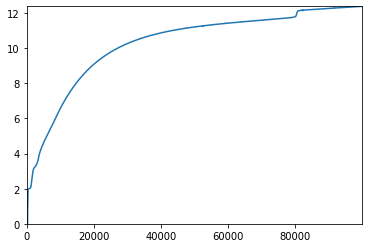

In [36]:
torch.manual_seed(0)
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('SM_toys/4.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1], AF = 'Sigmoid' , WC = 100)
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 100000, LearningRate = 1e-3, Optimiser = 'Adam')
start = time.time()
epoch, t = MT.Train1(MD, TData, TLabels, UseGPU = True)
print('Training time = ' + str((time.time()-start)/60.))
plt.axis([0, max(epoch), 0, max(t)])
plt.plot(epoch,t)


Reading file ...Reference_sample/1.h5

Reading file ...SM_toys/4.h5

Reference data lenght =  200000

Total number of training points  =  201965

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method sigmoid of type object at 0x7f340375fc40>
Training time = 7.805156973997752 999992


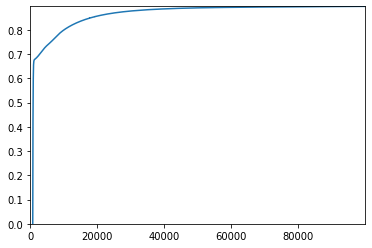

In [39]:
torch.manual_seed(0)
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('SM_toys/4.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1], AF = 'Sigmoid', WC = 0.001 )
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 100000, LearningRate = 1e-3, Optimiser = 'Adam')
start = time.time()
epoch, t = MT.Train(MD, TData, TLabels, UseGPU = True)
print('Training time = ' + str((time.time()-start)/60.))
plt.axis([0, max(epoch), 0, max(t)])
plt.plot(epoch,t)


Reading file ...Reference_sample/1.h5

Reading file ...SM_toys/40.h5

Reference data lenght =  200000

Total number of training points  =  202032

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method sigmoid of type object at 0x7f340375fc40>
Training time = 7.771069900194804 9999907


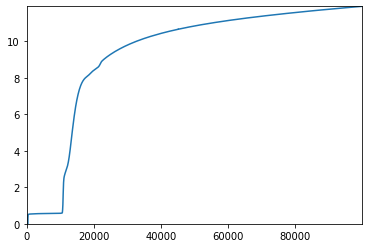

In [44]:
torch.manual_seed(0)
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('SM_toys/40.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1], AF = 'Sigmoid', WC = 100 )
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 100000, LearningRate = 1e-3, Optimiser = 'Adam')
start = time.time()
epoch, t = MT.Train(MD, TData, TLabels, UseGPU = True)
print('Training time = ' + str((time.time()-start)/60.))
plt.axis([0, max(epoch), 0, max(t)])
plt.plot(epoch,t)


Reading file ...Reference_sample/1.h5

Reading file ...SM_toys/41.h5

Reference data lenght =  200000

Total number of training points  =  201978

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method sigmoid of type object at 0x7f340375fc40>
Training time = 7.7603129347165429999984


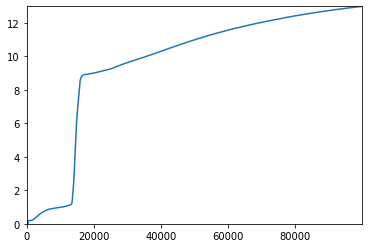

In [41]:
torch.manual_seed(0)
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('SM_toys/41.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1], AF = 'Sigmoid', WC = 100 )
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 100000, LearningRate = 1e-3, Optimiser = 'Adam')
start = time.time()
epoch, t = MT.Train(MD, TData, TLabels, UseGPU = True)
print('Training time = ' + str((time.time()-start)/60.))
plt.axis([0, max(epoch), 0, max(t)])
plt.plot(epoch,t)


Reading file ...Reference_sample/1.h5

Reading file ...SM_toys/141.h5

Reference data lenght =  200000

Total number of training points  =  202062

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method sigmoid of type object at 0x7f340375fc40>
Training time = 7.763207320372263 99999


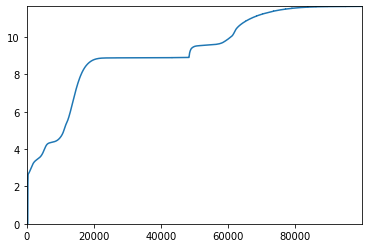

In [42]:
torch.manual_seed(0)
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('SM_toys/141.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1], AF = 'Sigmoid', WC = 100 )
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 100000, LearningRate = 1e-3, Optimiser = 'Adam')
start = time.time()
epoch, t = MT.Train(MD, TData, TLabels, UseGPU = True)
print('Training time = ' + str((time.time()-start)/60.))
plt.axis([0, max(epoch), 0, max(t)])
plt.plot(epoch,t)

In [37]:
torch.manual_seed(0)
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('SM_toys/4.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1], AF = 'Sigmoid' )
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 10000, LearningRate = 1e-3, Optimiser = 'Adam')
start = time.time()
epoch, t = MT.Train(MD, TData, TLabels, UseGPU = False)
print('Training time = ' + str((time.time()-start)/60.))
plt.axis([0, max(epoch), 0, max(t)])
plt.plot(epoch,t)


Reading file ...Reference_sample/1.h5

Reading file ...SM_toys/4.h5

Reference data lenght =  200000

Total number of training points  =  201965

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method sigmoid of type object at 0x7f340375fc40>


KeyboardInterrupt: 


Reading file ...Reference_sample/1.h5

Reading file ...BSM_toys/4.h5

Reference data lenght =  200000

Total number of training points  =  201911

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method sigmoid of type object at 0x7f340375fc40>
300
0.19603093055013687
14000
0.019555214454783254
54200
0.0019290559847036093
80900
0.00019243918812605898
22.259841637401635
Training time = 17.118347283204397


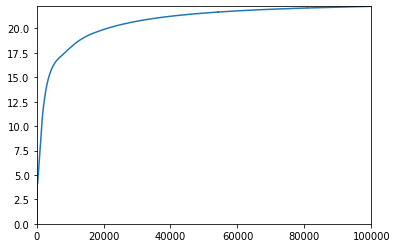

In [23]:
torch.manual_seed(0)
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('BSM_toys/4.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1], AF = 'Sigmoid' )
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 100000, LearningRate = 1e-3, Optimiser = 'Adam')
start = time.time()
epoch, t = MT.Train1(MD, TData, TLabels, UseGPU = True)
print('Training time = ' + str((time.time()-start)/60.))
plt.axis([0, 100000, 0, max(t)])
plt.plot(epoch,t)


Reading file ...Reference_sample/1.h5

Reading file ...BSM_toys/4.h5

Reference data lenght =  200000

Total number of training points  =  201911

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method sigmoid of type object at 0x7f340375fc40>
Training time = 18.03987449804941899999


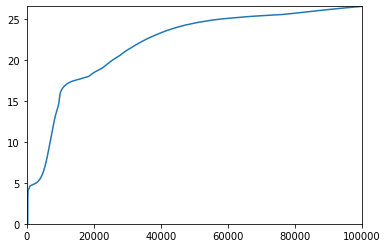

In [26]:
torch.manual_seed(0)
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('BSM_toys/4.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1], AF = 'Sigmoid' )
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 100000, LearningRate = 1e-3, Optimiser = 'Adam')
start = time.time()
epoch, t = MT.Train(MD, TData, TLabels, UseGPU = True)
print('Training time = ' + str((time.time()-start)/60.))
plt.axis([0, 100000, 0, max(t)])
plt.plot(epoch,t)


Reading file ...Reference_sample/1.h5

Reading file ...BSM_toys/4.h5

Reference data lenght =  200000

Total number of training points  =  201911

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method relu of type object at 0x7f340375fc40>
Training time = 17.654593197504678999993


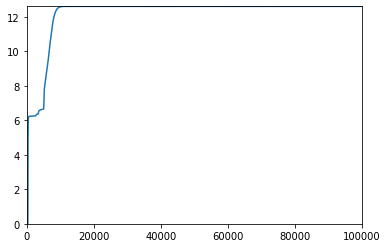

In [27]:
torch.manual_seed(0)
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('BSM_toys/4.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1], AF = 'ReLU' )
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 100000, LearningRate = 1e-3, Optimiser = 'Adam')
start = time.time()
epoch, t = MT.Train(MD, TData, TLabels, UseGPU = True)
print('Training time = ' + str((time.time()-start)/60.))
plt.axis([0, 100000, 0, max(t)])
plt.plot(epoch,t)


Reading file ...Reference_sample/1.h5

Reading file ...BSM_toys/4.h5

Reference data lenght =  200000

Total number of training points  =  201911

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method relu of type object at 0x7f340375fc40>
400
0.19692784137018293
1900
0.014499598145619075
2400
0.0013415239864684736
3000
8.427488091911073e-05
3100
1.8630029927635405e-06
3900
1.5241630535456352e-07
14300
1.2772289892382105e-08
12.614463713482706
Training time = 16.59430354833603


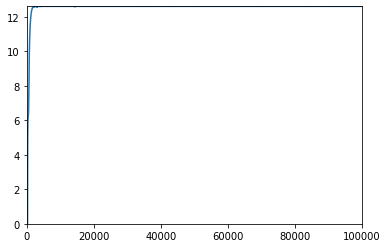

In [28]:
torch.manual_seed(0)
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('BSM_toys/4.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1], AF = 'ReLU' )
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 100000, LearningRate = 1e-3, Optimiser = 'Adam')
start = time.time()
epoch, t = MT.Train1(MD, TData, TLabels, UseGPU = True)
print('Training time = ' + str((time.time()-start)/60.))
plt.axis([0, 100000, 0, max(t)])
plt.plot(epoch,t)


Reading file ...Reference_sample/1.h5

Reading file ...BSM_toys/40.h5

Reference data lenght =  200000

Total number of training points  =  201999

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method sigmoid of type object at 0x11d7dbad0>
300
0.5612710383566691
21.363040359711167
Training time = 4.099389517307282


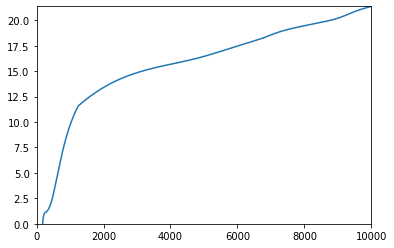

In [35]:
torch.manual_seed(0)
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('BSM_toys/40.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1], AF = 'Sigmoid' )
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 10000, LearningRate = 1e-3, Optimiser = 'Adam')
start = time.time()
epoch, t = MT.Train1(MD, TData, TLabels, UseGPU = False)
print('Training time = ' + str((time.time()-start)/60.))
plt.axis([0, 10000, 0, max(t)])
plt.plot(epoch,t)


Reading file ...Reference_sample/1.h5

Reading file ...BSM_toys/40.h5

Reference data lenght =  200000

Total number of training points  =  201999

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method sigmoid of type object at 0x11d7dbad0>
Training time = 3.7752942482630414999909


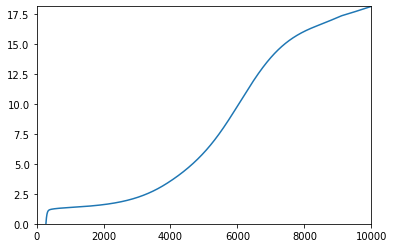

In [36]:
torch.manual_seed(0)
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('BSM_toys/40.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1], AF = 'Sigmoid' )
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 10000, LearningRate = 1e-3, Optimiser = 'Adam')
start = time.time()
epoch, t = MT.Train(MD, TData, TLabels, UseGPU = False)
print('Training time = ' + str((time.time()-start)/60.))
plt.axis([0, 10000, 0, max(t)])
plt.plot(epoch,t)


Reading file ...Reference_sample/1.h5

Reading file ...BSM_toys/4.h5

Reference data lenght =  200000

Total number of training points  =  201911

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method sigmoid of type object at 0x7f340375fc40>
300
0.24333550223671452
17.67702529853623
Training time = 1.929845404624939


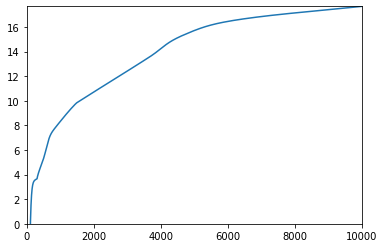

In [22]:
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('BSM_toys/4.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1], AF = 'Sigmoid' )
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 10000, LearningRate = 1e-3, Optimiser = 'Adam')
start = time.time()
epoch, t = MT.Train1(MD, TData, TLabels, UseGPU = False)
print('Training time = ' + str((time.time()-start)/60.))
plt.axis([0, 10000, 0, max(t)])
plt.plot(epoch,t)


Reading file ...Reference_sample/1.h5

Reading file ...BSM_toys/4.h5

Reference data lenght =  200000

Total number of training points  =  201911

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method sigmoid of type object at 0x11d7dbad0>
100
0.14482027918538698
4.595478043593705


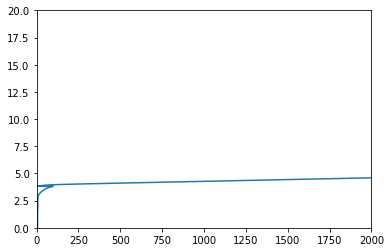

In [14]:
torch.manual_seed(0)
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('BSM_toys/4.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1], AF = 'Sigmoid' )
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 2000, LearningRate = 1e-4, Optimiser = 'SGD')
epoch, t = MT.Train1(MD, TData, TLabels, UseGPU = False)
plt.axis([0, 2000, 0, 20])
plt.plot(epoch,t)


Reading file ...Reference_sample/1.h5

Reading file ...BSM_toys/4.h5

Reference data lenght =  200000

Total number of training points  =  201911

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method sigmoid of type object at 0x113236ad0>
200
0.14326911428355604
12.892496913759976


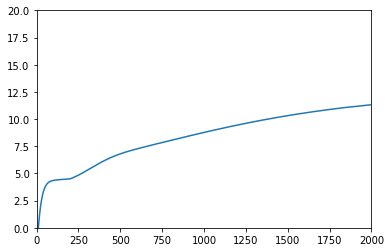

In [298]:
torch.manual_seed(1)
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('BSM_toys/4.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1], AF = 'Sigmoid' )
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 3000, LearningRate = 1e-3, Optimiser = 'Adam')
epoch, t = MT.Train1(MD, TData, TLabels)
plt.axis([0, 2000, 0, 20])
plt.plot(epoch,t)


Reading file ...Reference_sample/1.h5

Reading file ...BSM_toys/4.h5

Reference data lenght =  200000

Total number of training points  =  201911

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method relu of type object at 0x113236ad0>


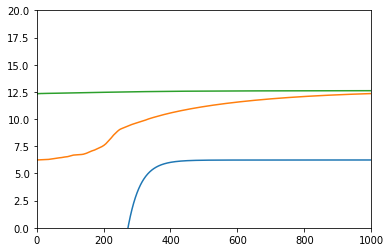

In [234]:
torch.manual_seed(0)
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('BSM_toys/4.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1] )
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 1000, LearningRate = 1e-3)
epoch, t = MT.Train(MD, TData, TLabels)
plt.axis([0, 1000, 0, 20])
plt.plot(epoch,t)
epoch, t = MT.Train(MD, TData, TLabels)
plt.axis([0, 1000, 0, 20])
plt.plot(epoch,t)
epoch, t = MT.Train(MD, TData, TLabels)
plt.axis([0, 1000, 0, 20])
plt.plot(epoch,t)


Reading file ...Reference_sample/1.h5

Reading file ...BSM_toys/4.h5

Reference data lenght =  200000

Total number of training points  =  201911

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method relu of type object at 0x113236ad0>


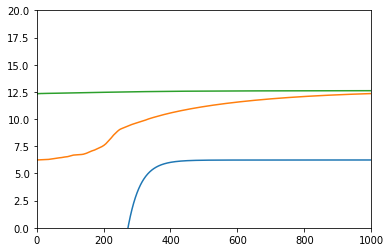

In [190]:
torch.manual_seed(0)
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('BSM_toys/4.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1] )
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 1000, LearningRate = 1e-3)
epoch, t = MT.Train(MD, TData, TLabels)
plt.axis([0, 1000, 0, 20])
plt.plot(epoch,t)
epoch, t = MT.Train(MD, TData, TLabels)
plt.axis([0, 1000, 0, 20])
plt.plot(epoch,t)
epoch, t = MT.Train(MD, TData, TLabels)
plt.axis([0, 1000, 0, 20])
plt.plot(epoch,t)


Reading file ...Reference_sample/1.h5

Reading file ...BSM_toys/4.h5

Reference data lenght =  200000

Total number of training points  =  201911

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method relu of type object at 0x113236ad0>


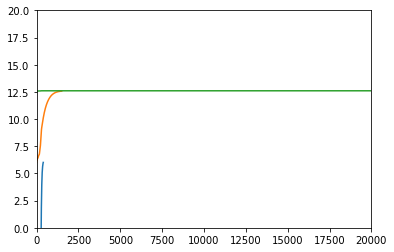

In [219]:
torch.manual_seed(0)
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('BSM_toys/4.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1] )
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 400, LearningRate = 1e-3)
epoch, t = MT.Train(MD, TData, TLabels)
plt.axis([0, 1000, 0, 20])
plt.plot(epoch,t)
MT = OurTrainer(Nexp/NRef, NumEpochs = 1500, LearningRate = 1e-3)
epoch, t = MT.Train(MD, TData, TLabels)
plt.axis([0, 2000, 0, 20])
plt.plot(epoch,t)
MT = OurTrainer(Nexp/NRef, NumEpochs = 20000, LearningRate = 1e-3)
epoch, t = MT.Train(MD, TData, TLabels)
plt.axis([0, 20000, 0, 20])
plt.plot(epoch,t)


Reading file ...Reference_sample/1.h5

Reading file ...BSM_toys/4.h5

Reference data lenght =  200000

Total number of training points  =  201911

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method relu of type object at 0x113236ad0>


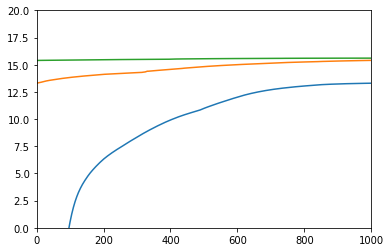

In [220]:
torch.manual_seed(1)
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('BSM_toys/4.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1] )
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 1000, LearningRate = 1e-3)
epoch, t = MT.Train(MD, TData, TLabels)
plt.axis([0, 1000, 0, 20])
plt.plot(epoch,t)
epoch, t = MT.Train(MD, TData, TLabels)
plt.axis([0, 1000, 0, 20])
plt.plot(epoch,t)
epoch, t = MT.Train(MD, TData, TLabels)
plt.axis([0, 1000, 0, 20])
plt.plot(epoch,t)


Reading file ...Reference_sample/1.h5

Reading file ...BSM_toys/4.h5

Reference data lenght =  200000

Total number of training points  =  201911

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method relu of type object at 0x113236ad0>


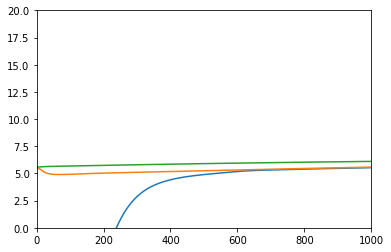

In [238]:
torch.manual_seed(1)
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('BSM_toys/4.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1] , WC = 0.01)
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 1000, LearningRate = 1e-3)
epoch, t = MT.Train(MD, TData, TLabels)
plt.axis([0, 1000, 0, 20])
plt.plot(epoch,t)
epoch, t = MT.Train(MD, TData, TLabels)
plt.axis([0, 1000, 0, 20])
plt.plot(epoch,t)
epoch, t = MT.Train(MD, TData, TLabels)
plt.axis([0, 1000, 0, 20])
plt.plot(epoch,t)


Reading file ...Reference_sample/1.h5

Reading file ...SM_toys/2.h5

Reference data lenght =  200000

Total number of training points  =  202008

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method relu of type object at 0x113236ad0>


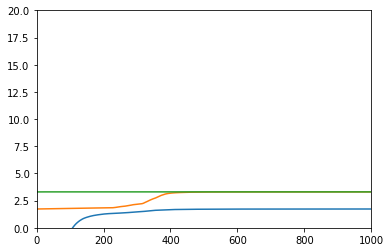

In [226]:
torch.manual_seed(1)
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('SM_toys/2.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1] )
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 1000, LearningRate = 1e-3)
epoch, t = MT.Train(MD, TData, TLabels)
plt.axis([0, 1000, 0, 20])
plt.plot(epoch,t)
epoch, t = MT.Train(MD, TData, TLabels)
plt.axis([0, 1000, 0, 20])
plt.plot(epoch,t)
epoch, t = MT.Train(MD, TData, TLabels)
plt.axis([0, 1000, 0, 20])
plt.plot(epoch,t)


Reading file ...Reference_sample/1.h5

Reading file ...BSM_toys/4.h5

Reference data lenght =  200000

Total number of training points  =  201911

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method relu of type object at 0x113236ad0>


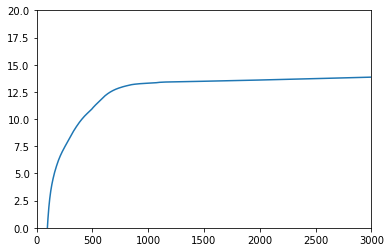

In [221]:
torch.manual_seed(1)
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('BSM_toys/4.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1] )
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 3000, LearningRate = 1e-3)
epoch, t = MT.Train(MD, TData, TLabels)
plt.axis([0, 3000, 0, 20])
plt.plot(epoch,t)


Reading file ...Reference_sample/1.h5

Reading file ...BSM_toys/4.h5

Reference data lenght =  200000

Total number of training points  =  201911

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method relu of type object at 0x113236ad0>


12.591827235504521

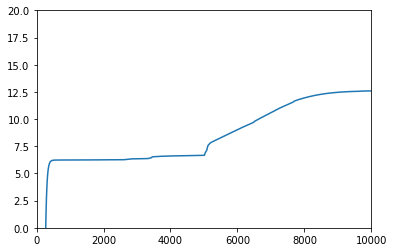

In [191]:
torch.manual_seed(0)
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('BSM_toys/4.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1] )
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 10000, LearningRate = 1e-3)
epoch, t = MT.Train(MD, TData, TLabels)
plt.axis([0, 10000, 0, 20])
plt.plot(epoch,t)
t[-1]

In [199]:
print(t[6101]-t[6000])
print(t[1100]-t[1000])
print(t[9100]-t[9000])

0.14600117181468697
0.001171126126410016
0.022899770520208307


In [188]:
t[999+10]

6.237883447736048


Reading file ...Reference_sample/1.h5

Reading file ...BSM_toys/4.h5

Reference data lenght =  200000

Total number of training points  =  201911

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method relu of type object at 0x113236ad0>


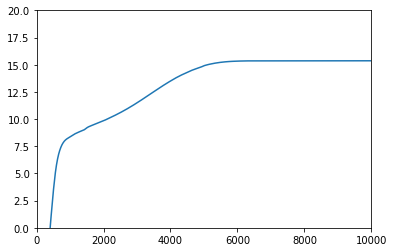

In [166]:
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('BSM_toys/4.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1] )
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef, NumEpochs = 10000, LearningRate = 1e-3)
epoch, t = MT.Train(MD, TData, TLabels)
plt.axis([0, 10000, 0, 20])
plt.plot(epoch,t)


Reading file ...Reference_sample/1.h5

Reading file ...BSM_toys/4.h5

Reference data lenght =  200000

Total number of training points  =  201911

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method relu of type object at 0x113236ad0>


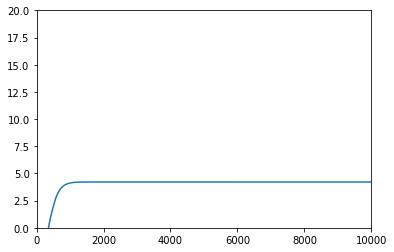

In [169]:
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('BSM_toys/4.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1] )
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef,NumEpochs = 10000, LearningRate = 1e-3)
epochprime, tprime = MT.Train(MD, TData, TLabels)
plt.axis([0, 10000, 0, 20])
plt.plot(epochprime,tprime)


Reading file ...Reference_sample/1.h5

Reading file ...BSM_toys/4.h5

Reference data lenght =  200000

Total number of training points  =  201911

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method relu of type object at 0x113236ad0>


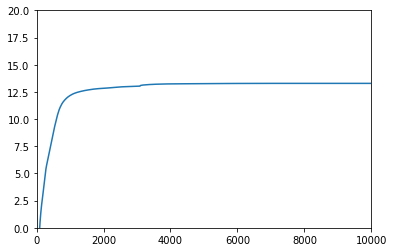

In [170]:
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('BSM_toys/4.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1] )
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef,NumEpochs = 10000, LearningRate = 1e-3)
epochsecond, tsecond = MT.Train(MD, TData, TLabels)
plt.axis([0, 10000, 0, 20])
plt.plot(epochsecond,tsecond)


Reading file ...Reference_sample/1.h5

Reading file ...BSM_toys/4.h5

Reference data lenght =  200000

Total number of training points  =  201911

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method relu of type object at 0x113236ad0>


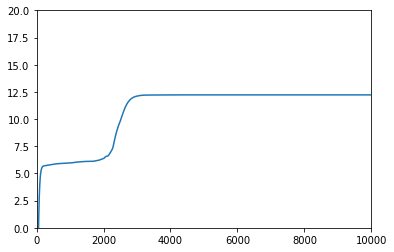

In [171]:
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('BSM_toys/4.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1] )
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef,NumEpochs = 10000, LearningRate = 1e-3)
epochthird, tthird = MT.Train(MD, TData, TLabels)
plt.axis([0, 10000, 0, 20])
plt.plot(epochthird,tthird)


Reading file ...Reference_sample/1.h5

Reading file ...BSM_toys/4.h5

Reference data lenght =  200000

Total number of training points  =  201911

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method relu of type object at 0x113236ad0>


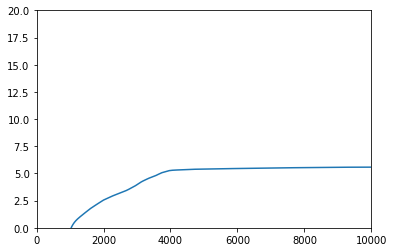

In [172]:
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('BSM_toys/4.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1] )
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef,NumEpochs = 10000, LearningRate = 1e-3)
epoch4, t4 = MT.Train(MD, TData, TLabels)
plt.axis([0, 10000, 0, 20])
plt.plot(epoch4,t4)


Reading file ...Reference_sample/1.h5

Reading file ...BSM_toys/4.h5

Reference data lenght =  200000

Total number of training points  =  201911

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method relu of type object at 0x113236ad0>


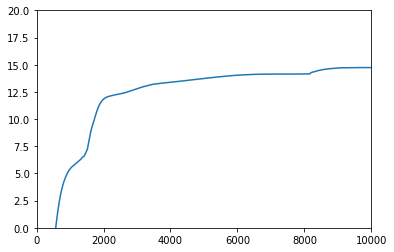

In [173]:
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('BSM_toys/4.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1] )
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef,NumEpochs = 10000, LearningRate = 1e-3)
epoch5, t5 = MT.Train(MD, TData, TLabels)
plt.axis([0, 10000, 0, 20])
plt.plot(epoch5,t5)


Reading file ...Reference_sample/1.h5

Reading file ...BSM_toys/4.h5

Reference data lenght =  200000

Total number of training points  =  201911

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method relu of type object at 0x113236ad0>


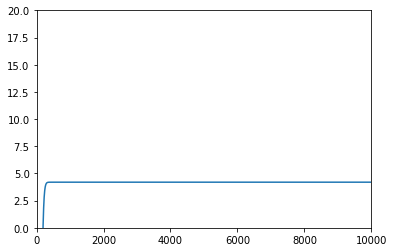

In [174]:
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('BSM_toys/4.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1] )
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef,NumEpochs = 10000, LearningRate = 1e-3)
epoch6, t6 = MT.Train(MD, TData, TLabels)
plt.axis([0, 10000, 0, 20])
plt.plot(epoch6,t6)


Reading file ...Reference_sample/1.h5

Reading file ...BSM_toys/4.h5

Reference data lenght =  200000

Total number of training points  =  201911

Initializing Preprocesses Variables

Model Report:
Preprocess Initialized: True
Architecture: [1, 4, 1]
Activation: <built-in method relu of type object at 0x113236ad0>


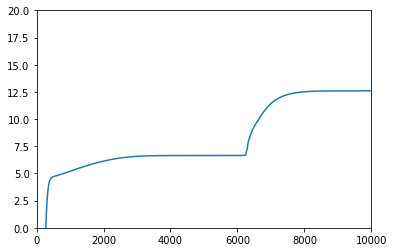

In [175]:
RF = DataFile('Reference_sample/1.h5')
DF = DataFile('BSM_toys/4.h5')
Nexp = 2000.
NRef = RF.Data.size()[0]
print('\nReference data lenght = ', NRef)
TData, TLabels = TrainingDataSample(RF.Data, DF.Data)
print('\nTotal number of training points  = ', TData.size(0))
MD = OurModel(AR = [1, 4, 1] )
MD.double()
MD.InitPreprocess(TData)
MD.Report()
MT = OurTrainer(Nexp/NRef,NumEpochs = 10000, LearningRate = 1e-3)
epoch8, t8 = MT.Train(MD, TData, TLabels)
plt.axis([0, 10000, 0, 20])
plt.plot(epoch8,t8)

In [70]:
MD = OurModel()
MD.double()
MD.Report()
MD.InitPreprocess(DF.Data)
MT = OurTrainer(ExpRoverRsize = 2000./RF.Data.size()[0])



Model Report:
Preprocess Initialized: False
Architecture: [1, 3, 3, 1]
Loss Function: Quadratic
Activation: <built-in method relu of type object at 0x113236ad0>

Initializing Preprocesses Variables


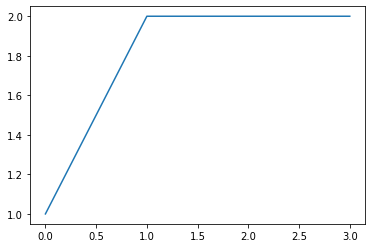

In [142]:
plt.plot([0,1,3],[1,2,2])

In [102]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  4
